In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mvcl.model import MetaVisualLearner
from mvcl.config import config

from datasets.sprites_base_dataset import SpritesBaseDataset
from rinarak.utils.tensor import logit, stats_summary
from rinarak.program import Program

[Taichi] version 1.7.0, llvm 15.0.7, commit 7b58b0ff, osx, python 3.9.13


[I 02/02/24 14:53:31.618 1049502] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


In [2]:
from rinarak.domain import *
domain_parser = Domain("mvcl/base.grammar")
meta_domain_str = f"""
(domain demo)
(:type
    object - vector[float,100]
    position - vector[float,2]
    color - vector[float, 64]
    category
)
(:predicate
    color ?x-object -> vector[float,100]
    shape ?x-object -> vector[float,100]

    red ?x-color -> boolean
    blue ?x-color -> boolean
    green ?x-color -> boolean

    square ?x-shape -> boolean
    circle ?x-shape -> boolean
    diamond ?x-shape -> boolean
)
(:derived
    is-good ?x-color expr: (??f ?x)
)
(:constraint
    (color: red blue green)
    (shape: square circle diamond)
)
"""
domain = load_domain_string(meta_domain_str, domain_parser)

In [3]:
"""Load Dataset Sprite Base"""
from torch.utils.data import DataLoader, Dataset
dataset = SpritesBaseDataset("train")
loader = DataLoader(dataset, batch_size = 1, shuffle = True)

In [4]:
from mvcl.custom import build_custom
config.concept_type = "cone"
model = MetaVisualLearner(domain, config)
model = build_custom(model, domain.domain_name)
model.perception.load_state_dict(torch.load("checkpoints/KFT_percept_backup.pth"))

<All keys matched successfully>

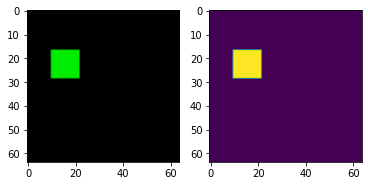

In [5]:
for sample in loader: break
imgs = sample["img"];masks = sample["masks"]
plt.subplot(121);plt.imshow(imgs[0].permute(1,2,0))
plt.subplot(122);plt.imshow(masks[0])

/Users/melkor/miniforge3/envs/Melkor/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/Users/melkor/miniforge3/envs/Melkor/lib/python3.9/site-packages/torch_sparse/storage.py:14: UserWarning: `layout` argument unset, using default layout "coo". This may lead to unexpected behaviour.
  warnings.warn('`layout` argument unset, using default layout '


tensor([1., 1., 0., 1., 1., 1., 1., 0., 0., 1.])


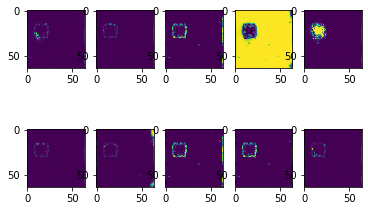

In [6]:
percept_outputs = model.perception(imgs, masks.unsqueeze(0).long())
all_masks = percept_outputs["masks"]
all_alives = percept_outputs["alive"]
for i in range(10):
    plt.subplot(2,5,1+i);plt.imshow(all_masks[0,:,:,i])
print(all_alives.flatten())

In [7]:
backbone_features = model.implementations["universal"](imgs)
b = 0
context = {
        "end":logit(all_alives[b].squeeze(-1)),
        "masks": logit(all_masks[b].permute(2,0,1).flatten(start_dim = 1, end_dim = 2)),
        "features": backbone_features[b].flatten(start_dim = 0, end_dim = 1),
        "model": model
    }

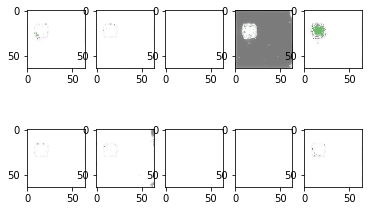

In [8]:
from rinarak.utils.tensor import stats_summary
"""Test the Expand Operator Works"""    
p = """(
            (Pr (color(expand (scene $0)) )  blue)
)
"""

p = Program.parse(p)
o = p.evaluate({0:context})
ends = o["end"].detach()
fig = plt.figure("ref-masks")
for i in range(ends.shape[0]):
    ax = fig.add_subplot(2,5,1+i)
    m = all_masks[b,:,:,i:i+1]
    #m = 1
    ax.imshow(m * imgs[b].permute(1,2,0)*ends[i].reshape([64,64,1]).sigmoid())

In [9]:
p = """
(
    intersect 
    (exists
        (intersect
            (Pr (color (expand (scene $0)) ) red) 
            (expand (scene $0))
        )
    )
    (scene $0)       
)
"""
p = Program.parse(p)
o = p.evaluate({0:context})
ends = o["end"].detach()
print(ends.sigmoid())

p = """
(
    intersect 
    (forall
        (union
            (Pr (color (expand (scene $0)) ) blue) 
            ( not (expand (scene $0)) )
        )
    )
    (scene $0)         
)
"""
p = Program.parse(p)
o = p.evaluate({0:context})
ends = o["end"].detach()
print(ends.sigmoid())

tensor([4.4414e-01, 3.9039e-01, 1.0000e-06, 4.6781e-01, 3.9522e-01, 3.8252e-01,
        4.9353e-01, 1.0000e-06, 1.0000e-06, 3.6422e-01])
tensor([5.0453e-01, 5.4606e-01, 1.0000e-06, 3.7212e-01, 4.6796e-01, 5.4820e-01,
        4.1105e-01, 1.0000e-06, 1.0000e-06, 5.1787e-01])


In [10]:
p1 = f"""(
    intersect 
    (forall
        (union
            (Pr (color (expand (scene $0)) ) {{}}) 
            ( not (expand (scene $0)) )
        )
    )
    (scene $0)         
)
"""
p2 = f"""(
    intersect 
    (exists
        (intersect
            (Pr (color (expand (scene $0)) ) {{}}) 
            (expand (scene $0))
        )
    )
    (scene $0)       
)
"""

In [11]:
backbone_features = model.implementations["universal"](imgs)
#print(backbone_features.shape)

In [12]:
import sys
for param in model.perception.parameters():
    param.requires_grad = False
for param in model.central_executor.parameters():
    param.requires_grad = True
optim = torch.optim.Adam(model.parameters(), lr = 2e-4)

outputs = model.perception(imgs, masks.long().unsqueeze(1))
backbone_features = outputs["features"]


for epoch in range(4000):
    b = 0
    backbone_features = model.implementations["universal"](imgs)
    context = {
        "end":logit(all_alives[b].squeeze(-1)),
        "masks": logit(all_masks[b].permute(2,0,1).flatten(start_dim = 1, end_dim = 2)),
        "features": backbone_features[b].flatten(start_dim = 0, end_dim = 1),
        "model": model
    }
    
    loss = 0.0
    u1 = 0
    u2 = 8
    bi = 6
    """
    o = Program.parse(p1.format("red")).evaluate({0:context})
    loss -= torch.log(torch.sigmoid(o["end"][u1]))

    o = Program.parse(p1.format("blue")).evaluate({0:context})
    loss -= torch.log(torch.sigmoid(o["end"][u2]))
    """

    # Forall Grounding
    # Existence Grounding
    o = Program.parse(p1.format("red")).evaluate({0:context})
    loss -= torch.log(torch.sigmoid(o["end"][u1]))
    loss -= torch.log(1 - torch.sigmoid(o["end"][u2]))

    o = Program.parse(p1.format("blue")).evaluate({0:context})
    loss -= torch.log(torch.sigmoid(o["end"][u2]))
    loss -= torch.log(1 - torch.sigmoid(o["end"][u1]))
    

    
    # Existence Grounding
    o = Program.parse(p2.format("red")).evaluate({0:context})
    loss -= torch.log(torch.sigmoid(o["end"][u1]))
    loss -= torch.log(1 - torch.sigmoid(o["end"][u2]))
    loss -= torch.log(1 - torch.sigmoid(o["end"][bi]))

    o = Program.parse(p2.format("blue")).evaluate({0:context})
    loss -= torch.log(torch.sigmoid(o["end"][u2]))
    loss -= torch.log(1 - torch.sigmoid(o["end"][u1]))
    loss -= torch.log(1 - torch.sigmoid(o["end"][bi]))

    optim.zero_grad()
    loss.backward()
    optim.step()
    vr=model.get_concept_embedding("red")
    vg=model.get_concept_embedding("blue")
    sys.stdout.write(f"\repoch:{epoch} loss:{loss} cos:{torch.cosine_similarity(vr,vg)}")

epoch:2 loss:30.557598114013672 cos:tensor([0.7562], grad_fn=<SumBackward1>)

KeyboardInterrupt: 

red


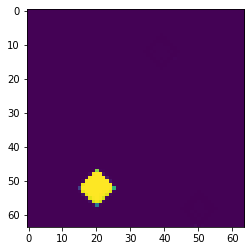

shape:[64, 64] max:6.016533851623535 min:-7.763792991638184
green


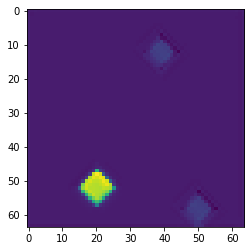

shape:[64, 64] max:0.9871131181716919 min:-2.119307041168213
blue


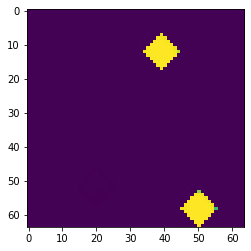

shape:[64, 64] max:5.572432518005371 min:-7.493286609649658


In [92]:
"""Evaluate the Property Map"""
from rinarak.utils.tensor import stats_summary
mapper = model.implementations["color"]
concept_feature_map = mapper(context["features"])
value_feature_maps = []
for value in ["red", "green", "blue"]:
    print(value)
    value_map = model.entailment(concept_feature_map, model.get_concept_embedding(value)).reshape([64,64])
    plt.imshow(value_map.sigmoid().detach())
    plt.show()
    stats_summary(value_map)